In [1]:
import sys
import torch
import itertools

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import Counter
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import NullFormatter

sys.path.insert(0, '/home/darryl/dev/LTFF/toy_model_interpretability')
from model_helper import *

In [2]:
# Reconstruct the model
def model_builder(N, m, k, nonlinearity):
    if nonlinearity == 'ReLU':
        activation = nn.ReLU()
    elif nonlinearity == 'GeLU':
        activation = nn.GELU()
    elif nonlinearity == 'SoLU':
        activation = lambda x: x*torch.exp(x)    
    
    model = torch.nn.Sequential(
                nn.Linear(m, k, bias=True),
                activation,
                nn.Linear(k, N, bias=False)
            )
    return model

In [3]:
def loss_func(batch_size, outputs, vectors):
    loss = np.sum((outputs - vectors)**2) / batch_size
    return loss

In [4]:
def sample_vectors_equal(N: int, eps: float, batch_size: int, embedder):
    """
        Generates random uniform vectors in a tensor of shape (N,batch_size)
        with sparsity 1-eps. These are returned as v.

        Applies embedding matrix to v to produce a low-dimensional embedding,
        returned as x.
    """

    v = torch.rand((int(batch_size), int(N)))
    
    compare = eps * torch.ones((int(batch_size), int(N)))
    sparsity = torch.bernoulli(compare)
            
    v *= sparsity
    x = torch.matmul(v,embedder.T) # Embeds features in a low-dimensional space

    return v, x

# Benchmark - single feature inputs of unit amplitude

In [5]:
model = 'model3'
# model='soft_dot_penalised_model'
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = -1.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.03
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
# lr = 0.001
lrs = [0.001,0.003,0.005,0.007,0.01,0.03]

In [6]:
print(lrs)

# Load and process data
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in lrs
])
ReLU_equal_lr_sweep = []
for n in names:
    try:
        ReLU_equal_lr_sweep.append(torch.load(n, map_location=torch.device('cpu')))
    except FileNotFoundError:
        print(n,'not found')

[0.001, 0.003, 0.005, 0.007, 0.01, 0.03]


In [7]:
brs = []
bls = []
bmls = []
for batch in ReLU_equal_lr_sweep:
    fixed_embedder = batch['setup']['fixed_embedder']
    d = batch['log2_spaced_models'][-1]

    model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], batch['nonlinearity'])
    model.load_state_dict(batch['log2_spaced_models'][-1])
    model.to('cpu')
    
    sfa = single_feature_activations(d, batch, batch['setup'])
    unit_sfa = np.array(sfa > 0.0, dtype='int')

    where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]
    mono_d = deepcopy(batch['log2_spaced_models'][-1])
    mono_d['0.weight'][where_poly, :] *= 0
    mono_d['0.bias'][where_poly] *= 0
    mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                               d['0.weight'].shape[0], batch['nonlinearity'])
    mono_model.load_state_dict(mono_d)
    mono_model.to('cpu')

    where_mono = np.where(np.sum(unit_sfa, axis=-1) == 1)[0]
    poly_d = deepcopy(batch['log2_spaced_models'][-1])
    poly_d['0.weight'][where_mono, :] *= 0
    poly_d['0.bias'][where_mono] *= 0
    poly_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                               d['0.weight'].shape[0], batch['nonlinearity'])
    poly_model.load_state_dict(poly_d)
    poly_model.to('cpu')
    
#     full_os = []
#     mono_os = []
#     poly_os = []
#     step_size = .01
#     for a in np.arange(0, 1 + step_size, step_size):
    vs = torch.eye(N)
#     vs = torch.eye(N) * a
    ins = torch.matmul(vs, fixed_embedder.T)
#         full_os.append(model.forward(ins).T.detach().numpy())
#         mono_os.append(mono_model.forward(ins).T.detach().numpy())
#         poly_os.append(poly_model.forward(ins).T.detach().numpy())
    brs.append((model.forward(ins).detach().numpy(),
              mono_model.forward(ins).detach().numpy(),
              poly_model.forward(ins).detach().numpy()))
    bls.append(loss_func(N, model.forward(ins).detach().numpy(), vs.detach().numpy()))
    bmls.append(loss_func(N, mono_model.forward(ins).detach().numpy(), vs.detach().numpy()))

In [8]:
bls

[0.011439724825322628,
 0.013296583667397499,
 0.01431959681212902,
 0.015047798864543438,
 0.017271945253014565,
 0.023196997120976448]

In [9]:
bmls

[0.2028513252735138,
 0.2352994829416275,
 0.2698226571083069,
 0.23689046502113342,
 0.2543613314628601,
 0.20651380717754364]

# Penalised - single feature inputs of unit amplitude

In [10]:
model = 'soft_dot_penalised_model'
init_bias = 0.0
decay = 0.0

In [11]:
print(lrs)

# Load and process data
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in lrs
])
ReLU_equal_lr_sweep = []
for n in names:
    try:
        ReLU_equal_lr_sweep.append(torch.load(n, map_location=torch.device('cpu')))
    except FileNotFoundError:
        print(n,'not found')

[0.001, 0.003, 0.005, 0.007, 0.01, 0.03]


In [12]:
pls = []
pmls = []
for batch in ReLU_equal_lr_sweep:
    fixed_embedder = batch['setup']['fixed_embedder']
    d = batch['log2_spaced_models'][-1]

    model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], batch['nonlinearity'])
    model.load_state_dict(batch['log2_spaced_models'][-1])
    model.to('cpu')
    
    sfa = single_feature_activations(d, batch, batch['setup'])
    unit_sfa = np.array(sfa > 0.0, dtype='int')

    where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]
    mono_d = deepcopy(batch['log2_spaced_models'][-1])
    mono_d['0.weight'][where_poly, :] *= 0
    mono_d['0.bias'][where_poly] *= 0
    mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                               d['0.weight'].shape[0], batch['nonlinearity'])
    mono_model.load_state_dict(mono_d)
    mono_model.to('cpu')
    
    vs = torch.eye(N)
    ins = torch.matmul(vs, fixed_embedder.T)
    pls.append(loss_func(N, model.forward(ins).detach().numpy(), vs.detach().numpy()))
    pmls.append(loss_func(N, mono_model.forward(ins).detach().numpy(), vs.detach().numpy()))

In [13]:
pls

[0.040988773107528687,
 0.01969296671450138,
 0.014535415917634964,
 0.017794741317629814,
 0.022493889555335045,
 1.0]

In [14]:
pmls

[0.040988773107528687,
 0.01969296671450138,
 0.014535415917634964,
 0.017794741317629814,
 0.022493889555335045,
 1.0]

In [15]:
np.mean(np.array(bmls[:-1]) - np.array(pmls[:-1]))

0.21674389503896235

In [16]:
np.array(bmls[:-1]) - np.array(pmls[:-1])

array([0.16186255, 0.21560652, 0.25528724, 0.21909572, 0.23186744])

In [17]:
np.array(bls[:-1]) - np.array(pmls[:-1])

array([-0.02954905, -0.00639638, -0.00021582, -0.00274694, -0.00522194])

In [18]:
np.mean(np.array(bls[:-1]) - np.array(pmls[:-1]))

-0.008826027438044549

# Benchmark - multiple feature inputs of random amplitude

In [19]:
model = 'model3'
# model='soft_dot_penalised_model'
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = -1.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.03
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
# lr = 0.001
lrs = [0.001,0.003,0.005,0.007,0.01,0.03]

In [20]:
print(lrs)

# Load and process data
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in lrs
])
ReLU_equal_lr_sweep = []
for n in names:
    try:
        ReLU_equal_lr_sweep.append(torch.load(n, map_location=torch.device('cpu')))
    except FileNotFoundError:
        print(n,'not found')

[0.001, 0.003, 0.005, 0.007, 0.01, 0.03]


In [21]:
btrials = []
for i in range(5):
    brs = []
    bls = []
    bmls = []
    for batch in ReLU_equal_lr_sweep:
        fixed_embedder = batch['setup']['fixed_embedder']
        d = batch['log2_spaced_models'][-1]
    
        model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], batch['nonlinearity'])
        model.load_state_dict(batch['log2_spaced_models'][-1])
        model.to('cpu')
        
        sfa = single_feature_activations(d, batch, batch['setup'])
        unit_sfa = np.array(sfa > 0.0, dtype='int')
    
        where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]
        mono_d = deepcopy(batch['log2_spaced_models'][-1])
        mono_d['0.weight'][where_poly, :] *= 0
        mono_d['0.bias'][where_poly] *= 0
        mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                                   d['0.weight'].shape[0], batch['nonlinearity'])
        mono_model.load_state_dict(mono_d)
        mono_model.to('cpu')
    
        where_mono = np.where(np.sum(unit_sfa, axis=-1) == 1)[0]
        poly_d = deepcopy(batch['log2_spaced_models'][-1])
        poly_d['0.weight'][where_mono, :] *= 0
        poly_d['0.bias'][where_mono] *= 0
        poly_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                                   d['0.weight'].shape[0], batch['nonlinearity'])
        poly_model.load_state_dict(poly_d)
        poly_model.to('cpu')
        
    #     full_os = []
    #     mono_os = []
    #     poly_os = []
    #     step_size = .01
    #     for a in np.arange(0, 1 + step_size, step_size):
    #     vs = torch.eye(N)
    #     vs = torch.eye(N) * a
    #     ins = torch.matmul(vs, fixed_embedder.T)
        vs, ins = sample_vectors_equal(N, eps, 2**log2_batch_size, fixed_embedder)
    #         full_os.append(model.forward(ins).T.detach().numpy())
    #         mono_os.append(mono_model.forward(ins).T.detach().numpy())
    #         poly_os.append(poly_model.forward(ins).T.detach().numpy())
        brs.append((model.forward(ins).detach().numpy(),
                  mono_model.forward(ins).detach().numpy(),
                  poly_model.forward(ins).detach().numpy()))
        bls.append(loss_func(2**log2_batch_size, model.forward(ins).detach().numpy(), vs.detach().numpy()))
        bmls.append(loss_func(2**log2_batch_size, mono_model.forward(ins).detach().numpy(), vs.detach().numpy()))
    btrials.append((bls, bmls))

In [22]:
bls

[0.8538400530815125,
 0.8584007024765015,
 0.8454532623291016,
 0.8551192879676819,
 0.8667556047439575,
 0.8755663633346558]

In [23]:
bmls

[1.3749494552612305,
 1.4476873874664307,
 1.5025246143341064,
 1.4557846784591675,
 1.4923856258392334,
 1.3817063570022583]

# Penalised - multiple feature inputs of random amplitude

In [24]:
model = 'soft_dot_penalised_model'
init_bias = 0.0
decay = 0.0

In [25]:
print(lrs)

# Load and process data
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in lrs
])
ReLU_equal_lr_sweep = []
for n in names:
    try:
        ReLU_equal_lr_sweep.append(torch.load(n, map_location=torch.device('cpu')))
    except FileNotFoundError:
        print(n,'not found')

[0.001, 0.003, 0.005, 0.007, 0.01, 0.03]


In [27]:
ptrials = []
for i in range(5):
    pls = []
    pmls = []
    for batch in ReLU_equal_lr_sweep:
        fixed_embedder = batch['setup']['fixed_embedder']
        d = batch['log2_spaced_models'][-1]
    
        model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], batch['nonlinearity'])
        model.load_state_dict(batch['log2_spaced_models'][-1])
        model.to('cpu')
        
        sfa = single_feature_activations(d, batch, batch['setup'])
        unit_sfa = np.array(sfa > 0.0, dtype='int')
    
        where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]
        mono_d = deepcopy(batch['log2_spaced_models'][-1])
        mono_d['0.weight'][where_poly, :] *= 0
        mono_d['0.bias'][where_poly] *= 0
        mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                                   d['0.weight'].shape[0], batch['nonlinearity'])
        mono_model.load_state_dict(mono_d)
        mono_model.to('cpu')
        
    #     vs = torch.eye(N)
    #     ins = torch.matmul(vs, fixed_embedder.T)
        vs, ins = sample_vectors_equal(N, eps, 2**log2_batch_size, fixed_embedder)
        pls.append(loss_func(2**log2_batch_size, model.forward(ins).detach().numpy(), vs.detach().numpy()))
        pmls.append(loss_func(2**log2_batch_size, mono_model.forward(ins).detach().numpy(), vs.detach().numpy()))
    ptrials.append((pls, pmls))

In [28]:
pls

[0.9315526485443115,
 0.9309137463569641,
 0.943163275718689,
 0.9541040658950806,
 0.965944766998291,
 2.679069757461548]

In [29]:
pmls

[0.9315526485443115,
 0.9309137463569641,
 0.943163275718689,
 0.9541040658950806,
 0.965944766998291,
 2.679069757461548]

In [30]:
np.mean(np.array(bmls[:-1]) - np.array(pmls[:-1]))

0.5095306515693665

In [31]:
np.array(bmls[:-1]) - np.array(pmls[:-1])

array([0.44339681, 0.51677364, 0.55936134, 0.50168061, 0.52644086])

In [32]:
np.array(bls[:-1]) - np.array(pmls[:-1])

array([-0.0777126 , -0.07251304, -0.09771001, -0.09898478, -0.09918916])

In [33]:
np.mean(np.array(bls[:-1]) - np.array(pmls[:-1]))

-0.08922191858291625

In [38]:
diffs = []
for i in range(5):
    diffs.append(np.mean(np.array(ptrials[i][0][:-1]) - np.array(btrials[i][0][:-1])))
print(diffs)
print(np.mean(diffs), np.mean(diffs)-1.96*(np.std(diffs)), np.mean(diffs)+1.96*(np.std(diffs)))

[0.07748225927352906, 0.09194588661193848, 0.08343621492385864, 0.08691940307617188, 0.08922191858291625]
0.08580113649368286 0.07598129016652523 0.09562098282084049


In [36]:
mdiffs = []
for i in range(5):
    mdiffs.append(np.mean(np.array(btrials[i][1][:-1]) - np.array(ptrials[i][1][:-1])))
print(mdiffs)
print(np.mean(mdiffs), np.mean(mdiffs)-1.96*(np.std(mdiffs)), np.mean(mdiffs)+1.96*(np.std(mdiffs)))

[0.5276235222816468, 0.5088677406311035, 0.5212194085121155, 0.5151287674903869, 0.5095306515693665]
0.5164740180969238 0.5024848987794084 0.5304631374144393


# Input visualisation

In [51]:
vs, ins = sample_vectors_equal(N, eps, 20, fixed_embedder)

In [52]:
print(vs)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


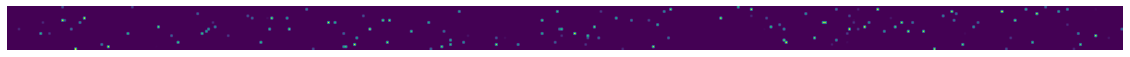

In [53]:
plt.figure(figsize=(20,20))
plt.imshow(vs)
plt.axis('off')
plt.show()

In [61]:
print(1 - np.sum(vs.detach().numpy() > 0, axis=1)/N)

[0.9921875  0.98242188 0.98632812 0.9921875  0.99023438 0.98046875
 0.98046875 0.97460938 0.99414062 0.98632812 0.97460938 0.98828125
 0.98046875 0.98828125 0.98242188 0.99414062 0.984375   0.98242188
 0.98828125 0.98632812]


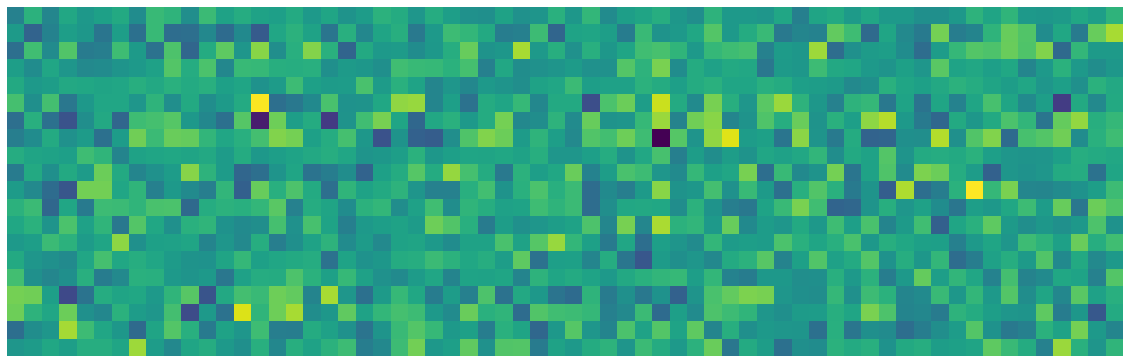

In [54]:
plt.figure(figsize=(20,20))
plt.imshow(ins)
plt.axis('off')
plt.show()